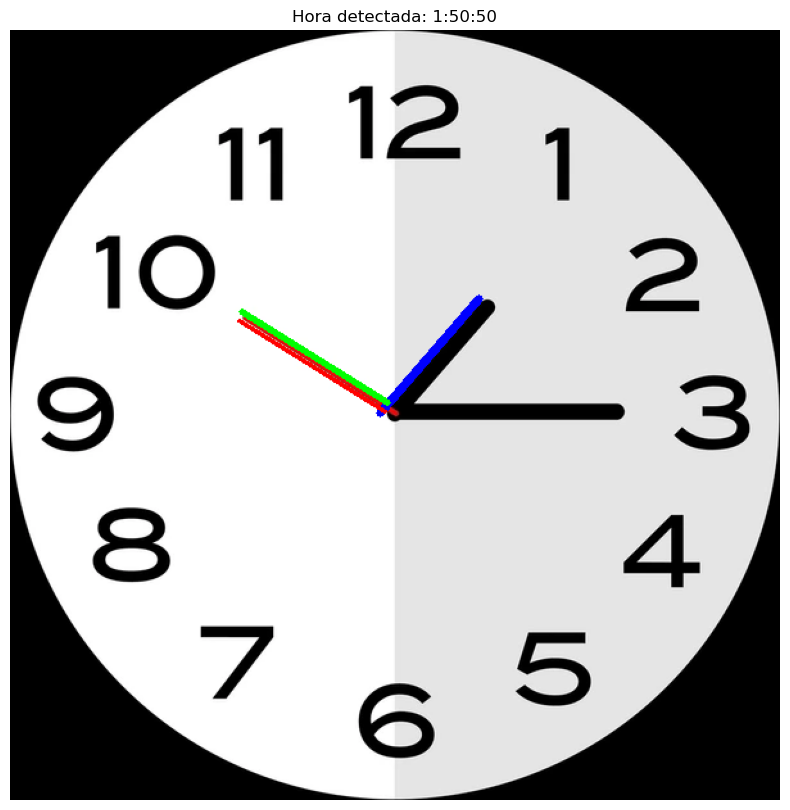

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
 
# Cargar imagen
imagen_bgr = cv2.imread('reloj4.png')
imagen_rgb = cv2.cvtColor(imagen_bgr, cv2.COLOR_BGR2RGB)
 
# Procesamiento en escala de grises
gris = cv2.cvtColor(imagen_bgr, cv2.COLOR_BGR2GRAY)
gris = cv2.GaussianBlur(gris, (5, 5), 1)
gris = cv2.equalizeHist(gris)
 
# Detección de bordes
bordes = cv2.Canny(gris, 50, 150)
 
# Detección de líneas
lineas = cv2.HoughLinesP(bordes, 1, np.pi/180, threshold=80, minLineLength=40, maxLineGap=15)
 
# Centro del reloj
centro_x = imagen_bgr.shape[1] // 2
centro_y = imagen_bgr.shape[0] // 2
 
# Función para calcular ángulo
def calcular_angulo(x1, y1, x2, y2):
    dist1 = np.hypot(x1 - centro_x, y1 - centro_y)
    dist2 = np.hypot(x2 - centro_x, y2 - centro_y)
    if dist1 > dist2:
        dx = x1 - centro_x
        dy = centro_y - y1
    else:
        dx = x2 - centro_x
        dy = centro_y - y2
    angulo = np.degrees(np.arctan2(dy, dx))
    angulo = (90 - angulo) % 360
    return angulo
 
# Filtrar líneas cerca del centro
manecillas = []
if lineas is not None:
    for linea in lineas:
        x1, y1, x2, y2 = linea[0]
        longitud = np.hypot(x2 - x1, y2 - y1)
        distancia_centro = min(np.hypot(x1 - centro_x, y1 - centro_y), np.hypot(x2 - centro_x, y2 - centro_y))
        
        # Filtrar líneas relevantes
        if distancia_centro < 100 and 30 < longitud < 400:
            angulo = calcular_angulo(x1, y1, x2, y2)
            manecillas.append({
                'puntos': (x1, y1, x2, y2),
                'longitud': longitud,
                'angulo': angulo
            })
 
# Identificar manecillas
if len(manecillas) >= 3:
    manecillas.sort(key=lambda x: x['longitud'])
    horario = manecillas[0]      # más corta -> hora
    minutero = manecillas[1]     # media -> minuto
    segundero = manecillas[2]    # más larga -> segundo
 
    # Cálculo de hora, minutos y segundos
    hora = int((horario['angulo'] / 30) % 12)
    minutos = int((minutero['angulo'] / 6) % 60)
    segundos = int((segundero['angulo'] / 6) % 60)
 
    # Corrección si la manecilla de hora está entre dos números
    fraccion_hora = (horario['angulo'] / 30) % 12
    if abs(fraccion_hora - hora) > 0.5:
        hora = (hora + 1) % 12
 
    # Dibujar resultado
    imagen_resultado = imagen_rgb.copy()
 
    # Dibujar manecillas
    cv2.line(imagen_resultado, (horario['puntos'][0], horario['puntos'][1]), (horario['puntos'][2], horario['puntos'][3]), (0, 0, 255), 6)  # Rojo - hora
    cv2.line(imagen_resultado, (minutero['puntos'][0], minutero['puntos'][1]), (minutero['puntos'][2], minutero['puntos'][3]), (0, 255, 0), 4)  # Verde - minuto
    cv2.line(imagen_resultado, (segundero['puntos'][0], segundero['puntos'][1]), (segundero['puntos'][2], segundero['puntos'][3]), (255, 0, 0), 2)  # Azul - segundo
 
    # Mostrar imagen
    plt.figure(figsize=(10, 10))
    plt.imshow(imagen_resultado)
    plt.title(f'Hora detectada: {hora}:{minutos:02d}:{segundos:02d}')
    plt.axis('off')
    plt.show()